In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import spectrogram, stft, istft, check_NOLA

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import os
import neptune
from neptune.utils import stringify_unsupported
from sklearn.preprocessing import StandardScaler

import scalpDeepModels as sdm

import importlib

plt.style.use('ggplot')

# PARAMETERS - GENERAL

In [3]:
patient = 'UFSEEG031'
targetScalpElectrodes = ['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4']
mode = 'Wake'

stftSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/freqRTheta_%s_%s_%s.npz' % (patient, targetScalpElectrodes, mode)
timeDomainSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeDomain_%s_%s_%s.npz' % (patient, targetScalpElectrodes, mode)
timeFreqSavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/timeFreqRTheta_%s_%s_%s.npz' % (patient, targetScalpElectrodes, mode)

modelPath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/pytorchModels/'

neptuneProject = 'jettinger35/predictScalp'
api_token = os.environ.get('NEPTUNE_API_TOKEN')

subsampleFreq = 128   # FINAL FREQUENCY IN HERTZ AFTER SUBSAMPLING
secondsInWindow = 1
nperseg = subsampleFreq * secondsInWindow
noverlap = nperseg - 1
window = ('tukey', .25)

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# PARAMETERS - TRAINING

In [4]:
epochs = 5000
batch_size = 1024
learningRate = 1e-3
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()
optChoice = 'adam'

patience = 5000

# UTILITY FUNCTIONS

In [5]:
# CONVERT STFT FROM R,THETA TO COMPLEX
# dim(z) = (# timesteps, # freq bins x 2 (2 reals = 1 complex))

def rThetaToComplex(z):
    rows, cols = z.shape
    shortTermFourier = np.zeros((rows, cols // 2), dtype=np.csingle)
    for i in range(rows):
        for k in range(cols // 2):
            r = z[i,k]
            theta = z[i, (k + cols // 2)]
            shortTermFourier[i,k] =  r * np.exp(complex(0, theta))
    return shortTermFourier.transpose() # dim = (# freq bins, # timepoints)

# CONVERT REAL STFT TO COMPLEX STFT, INVERT TO GET THE ISTFT (I.E. TIME SERIES), THEN PLOT

def realSTFTtoTimeSeries(realSTFT):
    shortTermFourierComplex = rThetaToComplex(realSTFT)
    times, inverseShortFourier = istft(shortTermFourierComplex, 
                                       fs=subsampleFreq, 
                                       window=window, 
                                       nperseg=nperseg, 
                                       noverlap=noverlap)
    return times, inverseShortFourier

# LOAD NUMPY DATA ARRAYS

In [5]:
dataSwitch = 'time'

if dataSwitch == 'freq':
    # STFT DATA

    npzfile = np.load(stftSavePath)
    x_trainRTheta = npzfile['x_trainRTheta']
    x_validRTheta = npzfile['x_validRTheta'] 
    y_trainRTheta = npzfile['y_trainRTheta'] 
    y_validRTheta = npzfile['y_validRTheta']

    trainXTensor = torch.Tensor(x_trainRTheta)
    trainYTensor = torch.Tensor(y_trainRTheta)
    validXTensor = torch.Tensor(x_validRTheta)
    validYTensor = torch.Tensor(y_validRTheta)

elif dataSwitch == 'time':
    # TIME DOMAIN DATA

    npzfile = np.load(timeDomainSavePath)
    xTrainTimeDomain = npzfile['xTrainTimeDomain']
    xValidTimeDomain = npzfile['xValidTimeDomain'] 
    yTrainTimeDomain = npzfile['yTrainTimeDomain'] 
    yValidTimeDomain = npzfile['yValidTimeDomain']

    trainXTensor = torch.Tensor(xTrainTimeDomain)
    trainYTensor = torch.Tensor(yTrainTimeDomain)
    validXTensor = torch.Tensor(xValidTimeDomain)
    validYTensor = torch.Tensor(yValidTimeDomain)
    
elif dataSwitch == 'timeFreq':
    
    npzfile = np.load(timeFreqSavePath)
    xTrain = npzfile['x_trainTimeFreq']
    xValid = npzfile['x_validTimeFreq'] 
    yTrain = npzfile['y_trainTimeFreq'] 
    yValid = npzfile['y_validTimeFreq']

    trainXTensor = torch.Tensor(xTrain)
    trainYTensor = torch.Tensor(yTrain)
    validXTensor = torch.Tensor(xValid)
    validYTensor = torch.Tensor(yValid)

In [6]:
# CREATE PYTORCH DATALOADERS

trainDataset = TensorDataset(trainXTensor,trainYTensor)
trainDataLoader = DataLoader(trainDataset,batch_size=batch_size, shuffle=True)

print("train: ")
for X, y in trainDataLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    
try:    
    validDataset = TensorDataset(validXTensor,validYTensor)
    validDataLoader = DataLoader(validDataset,batch_size=batch_size, shuffle=True)

    print("\ntest: ")
    for X, y in validDataLoader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}")
        break
        
    validFlag = True
except:
    validFlag = False
    print("No validation dataset...")

train: 
Shape of X [N, C, H, W]: torch.Size([1024, 5655])
Shape of y: torch.Size([1024, 1]) torch.float32
No validation dataset...


# DEFINE THE MODEL FOR TRAINING

In [7]:
# DEFINE MODEL

importlib.reload(sdm) # reload in case we've made any architecture changes

modelID = np.random.randint(0, 10**6)

# DEFINE ARCHITECTURE HERE
inputSize = trainXTensor.shape[1]
hiddenLayerSizes = [512,512,512,512,512,512]

layerDict = sdm.listToOrderedDict_1([inputSize] + hiddenLayerSizes)
#layerDict = sdm.residualAddDict(inputSize, 512, 5)
#layerDict = sdm.residualConcatDict(inputSize, hiddenLayerSizes)

model = nn.Sequential(layerDict)
bestTestLoss = float('inf')
    
print("Model ID: " + str(modelID))
print("Number of parameters: ", sdm.count_parameters(model))
model = model.to(device)
print(model)

Model ID: 279144
Number of parameters:  3963439
Sequential(
  (bn0): BatchNorm1d(5655, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l0): Linear(in_features=5655, out_features=512, bias=True)
  (r0): ReLU()
  (d0): Dropout(p=0.5, inplace=False)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): Linear(in_features=512, out_features=512, bias=True)
  (r1): ReLU()
  (d1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): Linear(in_features=512, out_features=512, bias=True)
  (r2): ReLU()
  (d2): Dropout(p=0.5, inplace=False)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Linear(in_features=512, out_features=512, bias=True)
  (r3): ReLU()
  (d3): Dropout(p=0.5, inplace=False)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=512, 

# TRAIN (LOG DATA TO NEPTUNE)

In [8]:
if optChoice == 'sgd':
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
elif optChoice == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
else:
    optimizer = None
    print('no optimizer chosen...')

run = neptune.init_run(
    project=neptuneProject,
    api_token=api_token,  
    capture_hardware_metrics=True,
    capture_stderr=True,
    capture_stdout=True,
)

PARAMS = {
    "modelID": modelID,
    "targetScalpElectrode": targetScalpElectrode,
    "batch_size": batch_size,
    "learning_rate": learningRate,
    "optimizer": optChoice,
    "patience": patience,
    "subsampleFreq": subsampleFreq,
    "secondsInWindow": secondsInWindow,
    "nperseg": nperseg,
    "noverlap": noverlap,
    "window": stringify_unsupported(window),
    "loss_fn": stringify_unsupported(loss_fn),
    "architectureString": str(model),
    "numParameters": sdm.count_parameters(model)
}
run["parameters"] = PARAMS

noImprovementCount = 0

#epochs = 2

try:
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss = sdm.train(trainDataLoader, model, loss_fn, optimizer, device)
        test_loss = sdm.test(validDataLoader, model, loss_fn, device)

        if test_loss < bestTestLoss:
            noImprovementCount = 0
            bestTestLoss = test_loss
            
            model_scripted = torch.jit.script(model) 
            model_scripted.save(modelPath + 'model_%s.pt' % str(modelID))
    
            run["best_test_loss"] =  bestTestLoss
            run["best_test_epoch"] = t
            print("\nSaved a new best model!\n")
        else:
            noImprovementCount = noImprovementCount + 1

        run["train/loss"].append(train_loss)
        run["test/loss"].append(test_loss)

        if noImprovementCount >= patience:   
            print("Early stopping invoked....")
            break

    run.stop()
    print("Done!")
except:
    run.stop()
    print("Training aborted...")

https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-67
Epoch 1
-------------------------------
loss: 0.823489  [ 1024/176128]
Test Error: 
 Avg loss: 0.667046 


Saved a new best model!

Epoch 2
-------------------------------
loss: 0.736638  [ 1024/176128]
Test Error: 
 Avg loss: 0.661986 


Saved a new best model!

Epoch 3
-------------------------------
loss: 0.737005  [ 1024/176128]
Test Error: 
 Avg loss: 0.658080 


Saved a new best model!

Epoch 4
-------------------------------
loss: 0.762069  [ 1024/176128]
Test Error: 
 Avg loss: 0.652616 


Saved a new best model!

Epoch 5
-------------------------------
loss: 0.751433  [ 1024/176128]
Test Error: 
 Avg loss: 0.644410 


Saved a new best model!

Epoch 6
-------------------------------
loss: 0.726495  [ 1024/176128]
Test Error: 
 Avg loss: 0.638026 


Saved a new best model!

Epoch 7
-------------------------------
loss: 0.686783  [ 1024/176128]
Test Error: 
 Avg loss: 0.634307 


Saved a new best model!

Epoch 8
-------

Test Error: 
 Avg loss: 0.552662 

Epoch 65
-------------------------------
loss: 0.563705  [ 1024/176128]
Test Error: 
 Avg loss: 0.550558 

Epoch 66
-------------------------------
loss: 0.567732  [ 1024/176128]
Test Error: 
 Avg loss: 0.548418 

Epoch 67
-------------------------------
loss: 0.561354  [ 1024/176128]
Test Error: 
 Avg loss: 0.543383 


Saved a new best model!

Epoch 68
-------------------------------
loss: 0.547267  [ 1024/176128]
Test Error: 
 Avg loss: 0.539543 


Saved a new best model!

Epoch 69
-------------------------------
loss: 0.553309  [ 1024/176128]
Test Error: 
 Avg loss: 0.536668 


Saved a new best model!

Epoch 70
-------------------------------
loss: 0.511027  [ 1024/176128]
Test Error: 
 Avg loss: 0.535632 


Saved a new best model!

Epoch 71
-------------------------------
loss: 0.526483  [ 1024/176128]
Test Error: 
 Avg loss: 0.535790 

Epoch 72
-------------------------------
loss: 0.539025  [ 1024/176128]
Test Error: 
 Avg loss: 0.536188 

Epoch

Test Error: 
 Avg loss: 0.520985 


Saved a new best model!

Epoch 135
-------------------------------
loss: 0.500605  [ 1024/176128]
Test Error: 
 Avg loss: 0.522968 

Epoch 136
-------------------------------
loss: 0.532088  [ 1024/176128]
Test Error: 
 Avg loss: 0.526838 

Epoch 137
-------------------------------
loss: 0.533931  [ 1024/176128]
Test Error: 
 Avg loss: 0.530153 

Epoch 138
-------------------------------
loss: 0.509920  [ 1024/176128]
Test Error: 
 Avg loss: 0.529764 

Epoch 139
-------------------------------
loss: 0.507664  [ 1024/176128]
Test Error: 
 Avg loss: 0.527061 

Epoch 140
-------------------------------
loss: 0.526592  [ 1024/176128]
Test Error: 
 Avg loss: 0.522791 

Epoch 141
-------------------------------
loss: 0.509924  [ 1024/176128]
Test Error: 
 Avg loss: 0.520383 


Saved a new best model!

Epoch 142
-------------------------------
loss: 0.523566  [ 1024/176128]
Test Error: 
 Avg loss: 0.520585 

Epoch 143
-------------------------------
loss: 0

Test Error: 
 Avg loss: 0.517170 

Epoch 209
-------------------------------
loss: 0.512249  [ 1024/176128]
Test Error: 
 Avg loss: 0.516920 

Epoch 210
-------------------------------
loss: 0.479695  [ 1024/176128]
Test Error: 
 Avg loss: 0.517202 

Epoch 211
-------------------------------
loss: 0.501183  [ 1024/176128]
Test Error: 
 Avg loss: 0.517350 

Epoch 212
-------------------------------
loss: 0.529793  [ 1024/176128]
Test Error: 
 Avg loss: 0.517175 

Epoch 213
-------------------------------
loss: 0.500886  [ 1024/176128]
Test Error: 
 Avg loss: 0.518485 

Epoch 214
-------------------------------
loss: 0.468123  [ 1024/176128]
Test Error: 
 Avg loss: 0.521703 

Epoch 215
-------------------------------
loss: 0.488656  [ 1024/176128]
Test Error: 
 Avg loss: 0.526542 

Epoch 216
-------------------------------
loss: 0.498602  [ 1024/176128]
Test Error: 
 Avg loss: 0.530860 

Epoch 217
-------------------------------
loss: 0.509279  [ 1024/176128]
Test Error: 
 Avg loss: 0.52

Test Error: 
 Avg loss: 0.520488 

Epoch 285
-------------------------------
loss: 0.478250  [ 1024/176128]
Test Error: 
 Avg loss: 0.523015 

Epoch 286
-------------------------------
loss: 0.471122  [ 1024/176128]
Test Error: 
 Avg loss: 0.523241 

Epoch 287
-------------------------------
loss: 0.504478  [ 1024/176128]
Test Error: 
 Avg loss: 0.520721 

Epoch 288
-------------------------------
loss: 0.488237  [ 1024/176128]
Test Error: 
 Avg loss: 0.518117 

Epoch 289
-------------------------------
loss: 0.509239  [ 1024/176128]
Test Error: 
 Avg loss: 0.515892 

Epoch 290
-------------------------------
loss: 0.496487  [ 1024/176128]
Test Error: 
 Avg loss: 0.514516 

Epoch 291
-------------------------------
loss: 0.474087  [ 1024/176128]
Test Error: 
 Avg loss: 0.513908 


Saved a new best model!

Epoch 292
-------------------------------
loss: 0.484210  [ 1024/176128]
Test Error: 
 Avg loss: 0.513631 


Saved a new best model!

Epoch 293
-------------------------------
loss: 0

Test Error: 
 Avg loss: 0.508105 


Saved a new best model!

Epoch 359
-------------------------------
loss: 0.464010  [ 1024/176128]
Test Error: 
 Avg loss: 0.508669 

Epoch 360
-------------------------------
loss: 0.468113  [ 1024/176128]
Test Error: 
 Avg loss: 0.511107 

Epoch 361
-------------------------------
loss: 0.490507  [ 1024/176128]
Test Error: 
 Avg loss: 0.509578 

Epoch 362
-------------------------------
loss: 0.490627  [ 1024/176128]
Test Error: 
 Avg loss: 0.510537 

Epoch 363
-------------------------------
loss: 0.451058  [ 1024/176128]
Test Error: 
 Avg loss: 0.514661 

Epoch 364
-------------------------------
loss: 0.481576  [ 1024/176128]
Test Error: 
 Avg loss: 0.516111 

Epoch 365
-------------------------------
loss: 0.458772  [ 1024/176128]
Test Error: 
 Avg loss: 0.515196 

Epoch 366
-------------------------------
loss: 0.470923  [ 1024/176128]
Test Error: 
 Avg loss: 0.514011 

Epoch 367
-------------------------------
loss: 0.496697  [ 1024/176128]
Te

Test Error: 
 Avg loss: 0.521290 

Epoch 435
-------------------------------
loss: 0.436436  [ 1024/176128]
Test Error: 
 Avg loss: 0.519232 

Epoch 436
-------------------------------
loss: 0.465092  [ 1024/176128]
Test Error: 
 Avg loss: 0.517108 

Epoch 437
-------------------------------
loss: 0.446240  [ 1024/176128]
Test Error: 
 Avg loss: 0.514890 

Epoch 438
-------------------------------
loss: 0.454667  [ 1024/176128]
Test Error: 
 Avg loss: 0.513550 

Epoch 439
-------------------------------
loss: 0.484221  [ 1024/176128]
Test Error: 
 Avg loss: 0.512494 

Epoch 440
-------------------------------
loss: 0.449880  [ 1024/176128]
Test Error: 
 Avg loss: 0.512589 

Epoch 441
-------------------------------
loss: 0.462145  [ 1024/176128]
Test Error: 
 Avg loss: 0.512302 

Epoch 442
-------------------------------
loss: 0.476760  [ 1024/176128]
Test Error: 
 Avg loss: 0.511980 

Epoch 443
-------------------------------
loss: 0.484468  [ 1024/176128]
Test Error: 
 Avg loss: 0.51

Test Error: 
 Avg loss: 0.516447 

Epoch 511
-------------------------------
loss: 0.444536  [ 1024/176128]
Test Error: 
 Avg loss: 0.517964 

Epoch 512
-------------------------------
loss: 0.444763  [ 1024/176128]
Test Error: 
 Avg loss: 0.517016 

Epoch 513
-------------------------------
loss: 0.466753  [ 1024/176128]
Test Error: 
 Avg loss: 0.516417 

Epoch 514
-------------------------------
loss: 0.464811  [ 1024/176128]
Test Error: 
 Avg loss: 0.515212 

Epoch 515
-------------------------------
loss: 0.463743  [ 1024/176128]
Test Error: 
 Avg loss: 0.514576 

Epoch 516
-------------------------------
loss: 0.453064  [ 1024/176128]
Test Error: 
 Avg loss: 0.516359 

Epoch 517
-------------------------------
loss: 0.464055  [ 1024/176128]
Test Error: 
 Avg loss: 0.519232 

Epoch 518
-------------------------------
loss: 0.460347  [ 1024/176128]
Test Error: 
 Avg loss: 0.523284 

Epoch 519
-------------------------------
loss: 0.456567  [ 1024/176128]
Test Error: 
 Avg loss: 0.52

Test Error: 
 Avg loss: 0.521751 

Epoch 587
-------------------------------
loss: 0.447803  [ 1024/176128]
Test Error: 
 Avg loss: 0.518008 

Epoch 588
-------------------------------
loss: 0.460398  [ 1024/176128]
Test Error: 
 Avg loss: 0.516644 

Epoch 589
-------------------------------
loss: 0.476207  [ 1024/176128]
Test Error: 
 Avg loss: 0.516528 

Epoch 590
-------------------------------
loss: 0.429581  [ 1024/176128]
Test Error: 
 Avg loss: 0.517130 

Epoch 591
-------------------------------
loss: 0.454515  [ 1024/176128]
Test Error: 
 Avg loss: 0.516950 

Epoch 592
-------------------------------
loss: 0.447265  [ 1024/176128]
Test Error: 
 Avg loss: 0.517091 

Epoch 593
-------------------------------
loss: 0.428494  [ 1024/176128]
Test Error: 
 Avg loss: 0.517999 

Epoch 594
-------------------------------
loss: 0.475320  [ 1024/176128]
Test Error: 
 Avg loss: 0.519586 

Epoch 595
-------------------------------
loss: 0.446710  [ 1024/176128]
Test Error: 
 Avg loss: 0.52

Test Error: 
 Avg loss: 0.518811 

Epoch 663
-------------------------------
loss: 0.420997  [ 1024/176128]
Test Error: 
 Avg loss: 0.521463 

Epoch 664
-------------------------------
loss: 0.461426  [ 1024/176128]
Test Error: 
 Avg loss: 0.524047 

Epoch 665
-------------------------------
loss: 0.461743  [ 1024/176128]
Test Error: 
 Avg loss: 0.526808 

Epoch 666
-------------------------------
loss: 0.449972  [ 1024/176128]
Test Error: 
 Avg loss: 0.525655 

Epoch 667
-------------------------------
loss: 0.425820  [ 1024/176128]
Test Error: 
 Avg loss: 0.523418 

Epoch 668
-------------------------------
loss: 0.432086  [ 1024/176128]
Test Error: 
 Avg loss: 0.522012 

Epoch 669
-------------------------------
loss: 0.452404  [ 1024/176128]
Test Error: 
 Avg loss: 0.522177 

Epoch 670
-------------------------------
loss: 0.435628  [ 1024/176128]
Test Error: 
 Avg loss: 0.523385 

Epoch 671
-------------------------------
loss: 0.426136  [ 1024/176128]
Test Error: 
 Avg loss: 0.52

Test Error: 
 Avg loss: 0.516293 

Epoch 739
-------------------------------
loss: 0.414714  [ 1024/176128]
Test Error: 
 Avg loss: 0.515808 

Epoch 740
-------------------------------
loss: 0.420466  [ 1024/176128]
Test Error: 
 Avg loss: 0.515282 

Epoch 741
-------------------------------
loss: 0.423653  [ 1024/176128]
Test Error: 
 Avg loss: 0.515191 

Epoch 742
-------------------------------
loss: 0.407924  [ 1024/176128]
Test Error: 
 Avg loss: 0.515717 

Epoch 743
-------------------------------
loss: 0.435300  [ 1024/176128]
Test Error: 
 Avg loss: 0.516794 

Epoch 744
-------------------------------
loss: 0.431793  [ 1024/176128]
Test Error: 
 Avg loss: 0.516886 

Epoch 745
-------------------------------
loss: 0.445458  [ 1024/176128]
Test Error: 
 Avg loss: 0.517172 

Epoch 746
-------------------------------
loss: 0.418018  [ 1024/176128]
Test Error: 
 Avg loss: 0.517465 

Epoch 747
-------------------------------
loss: 0.411366  [ 1024/176128]
Test Error: 
 Avg loss: 0.51

Test Error: 
 Avg loss: 0.525770 

Epoch 815
-------------------------------
loss: 0.400253  [ 1024/176128]
Test Error: 
 Avg loss: 0.524362 

Epoch 816
-------------------------------
loss: 0.393101  [ 1024/176128]
Test Error: 
 Avg loss: 0.522897 

Epoch 817
-------------------------------
loss: 0.409543  [ 1024/176128]
Test Error: 
 Avg loss: 0.522032 

Epoch 818
-------------------------------
loss: 0.422362  [ 1024/176128]
Test Error: 
 Avg loss: 0.523412 

Epoch 819
-------------------------------
loss: 0.410007  [ 1024/176128]
Test Error: 
 Avg loss: 0.523734 

Epoch 820
-------------------------------
loss: 0.434929  [ 1024/176128]
Test Error: 
 Avg loss: 0.522552 

Epoch 821
-------------------------------
loss: 0.402822  [ 1024/176128]
Test Error: 
 Avg loss: 0.522940 

Epoch 822
-------------------------------
loss: 0.403262  [ 1024/176128]
Test Error: 
 Avg loss: 0.526367 

Epoch 823
-------------------------------
loss: 0.425686  [ 1024/176128]
Test Error: 
 Avg loss: 0.53

Test Error: 
 Avg loss: 0.520495 

Epoch 891
-------------------------------
loss: 0.406017  [ 1024/176128]
Test Error: 
 Avg loss: 0.519404 

Epoch 892
-------------------------------
loss: 0.407513  [ 1024/176128]
Test Error: 
 Avg loss: 0.519112 

Epoch 893
-------------------------------
loss: 0.411636  [ 1024/176128]
Test Error: 
 Avg loss: 0.519190 

Epoch 894
-------------------------------
loss: 0.417392  [ 1024/176128]
Test Error: 
 Avg loss: 0.519520 

Epoch 895
-------------------------------
loss: 0.420863  [ 1024/176128]
Test Error: 
 Avg loss: 0.520238 

Epoch 896
-------------------------------
loss: 0.431660  [ 1024/176128]
Test Error: 
 Avg loss: 0.521751 

Epoch 897
-------------------------------
loss: 0.407062  [ 1024/176128]
Test Error: 
 Avg loss: 0.524749 

Epoch 898
-------------------------------
loss: 0.411711  [ 1024/176128]
Test Error: 
 Avg loss: 0.526725 

Epoch 899
-------------------------------
loss: 0.405494  [ 1024/176128]
Test Error: 
 Avg loss: 0.52

Test Error: 
 Avg loss: 0.524891 

Epoch 967
-------------------------------
loss: 0.419302  [ 1024/176128]
Test Error: 
 Avg loss: 0.522184 

Epoch 968
-------------------------------
loss: 0.418748  [ 1024/176128]
Test Error: 
 Avg loss: 0.519235 

Epoch 969
-------------------------------
loss: 0.408508  [ 1024/176128]
Test Error: 
 Avg loss: 0.518902 

Epoch 970
-------------------------------
loss: 0.398847  [ 1024/176128]
Test Error: 
 Avg loss: 0.520681 

Epoch 971
-------------------------------
loss: 0.396401  [ 1024/176128]
Test Error: 
 Avg loss: 0.522499 

Epoch 972
-------------------------------
loss: 0.423434  [ 1024/176128]
Test Error: 
 Avg loss: 0.524759 

Epoch 973
-------------------------------
loss: 0.427760  [ 1024/176128]
Test Error: 
 Avg loss: 0.524589 

Epoch 974
-------------------------------
loss: 0.383566  [ 1024/176128]
Test Error: 
 Avg loss: 0.526513 

Epoch 975
-------------------------------
loss: 0.412140  [ 1024/176128]
Test Error: 
 Avg loss: 0.52

Test Error: 
 Avg loss: 0.519674 

Epoch 1043
-------------------------------
loss: 0.397592  [ 1024/176128]
Test Error: 
 Avg loss: 0.520501 

Epoch 1044
-------------------------------
loss: 0.383561  [ 1024/176128]
Test Error: 
 Avg loss: 0.521622 

Epoch 1045
-------------------------------
loss: 0.406372  [ 1024/176128]
Test Error: 
 Avg loss: 0.523289 

Epoch 1046
-------------------------------
loss: 0.395375  [ 1024/176128]
Test Error: 
 Avg loss: 0.524758 

Epoch 1047
-------------------------------
loss: 0.405695  [ 1024/176128]
Test Error: 
 Avg loss: 0.524778 

Epoch 1048
-------------------------------
loss: 0.387779  [ 1024/176128]
Test Error: 
 Avg loss: 0.524177 

Epoch 1049
-------------------------------
loss: 0.413680  [ 1024/176128]
Test Error: 
 Avg loss: 0.522964 

Epoch 1050
-------------------------------
loss: 0.410606  [ 1024/176128]
Test Error: 
 Avg loss: 0.522805 

Epoch 1051
-------------------------------
loss: 0.384365  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.524710 

Epoch 1119
-------------------------------
loss: 0.388933  [ 1024/176128]
Test Error: 
 Avg loss: 0.523128 

Epoch 1120
-------------------------------
loss: 0.407798  [ 1024/176128]
Test Error: 
 Avg loss: 0.521280 

Epoch 1121
-------------------------------
loss: 0.390048  [ 1024/176128]
Test Error: 
 Avg loss: 0.521364 

Epoch 1122
-------------------------------
loss: 0.379679  [ 1024/176128]
Test Error: 
 Avg loss: 0.522485 

Epoch 1123
-------------------------------
loss: 0.421186  [ 1024/176128]
Test Error: 
 Avg loss: 0.524305 

Epoch 1124
-------------------------------
loss: 0.382865  [ 1024/176128]
Test Error: 
 Avg loss: 0.526324 

Epoch 1125
-------------------------------
loss: 0.386005  [ 1024/176128]
Test Error: 
 Avg loss: 0.526855 

Epoch 1126
-------------------------------
loss: 0.381999  [ 1024/176128]
Test Error: 
 Avg loss: 0.526891 

Epoch 1127
-------------------------------
loss: 0.363706  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.524211 

Epoch 1195
-------------------------------
loss: 0.364708  [ 1024/176128]
Test Error: 
 Avg loss: 0.525589 

Epoch 1196
-------------------------------
loss: 0.346431  [ 1024/176128]
Test Error: 
 Avg loss: 0.526793 

Epoch 1197
-------------------------------
loss: 0.376122  [ 1024/176128]
Test Error: 
 Avg loss: 0.528228 

Epoch 1198
-------------------------------
loss: 0.386506  [ 1024/176128]
Test Error: 
 Avg loss: 0.528951 

Epoch 1199
-------------------------------
loss: 0.394197  [ 1024/176128]
Test Error: 
 Avg loss: 0.528365 

Epoch 1200
-------------------------------
loss: 0.390251  [ 1024/176128]
Test Error: 
 Avg loss: 0.527745 

Epoch 1201
-------------------------------
loss: 0.381770  [ 1024/176128]
Test Error: 
 Avg loss: 0.527724 

Epoch 1202
-------------------------------
loss: 0.386802  [ 1024/176128]
Test Error: 
 Avg loss: 0.525761 

Epoch 1203
-------------------------------
loss: 0.385126  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.525469 

Epoch 1271
-------------------------------
loss: 0.390081  [ 1024/176128]
Test Error: 
 Avg loss: 0.524058 

Epoch 1272
-------------------------------
loss: 0.401956  [ 1024/176128]
Test Error: 
 Avg loss: 0.522824 

Epoch 1273
-------------------------------
loss: 0.389922  [ 1024/176128]
Test Error: 
 Avg loss: 0.521575 

Epoch 1274
-------------------------------
loss: 0.385783  [ 1024/176128]
Test Error: 
 Avg loss: 0.521052 

Epoch 1275
-------------------------------
loss: 0.377395  [ 1024/176128]
Test Error: 
 Avg loss: 0.520822 

Epoch 1276
-------------------------------
loss: 0.379674  [ 1024/176128]
Test Error: 
 Avg loss: 0.521314 

Epoch 1277
-------------------------------
loss: 0.370743  [ 1024/176128]
Test Error: 
 Avg loss: 0.523259 

Epoch 1278
-------------------------------
loss: 0.386897  [ 1024/176128]
Test Error: 
 Avg loss: 0.525445 

Epoch 1279
-------------------------------
loss: 0.364798  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521813 

Epoch 1347
-------------------------------
loss: 0.374657  [ 1024/176128]
Test Error: 
 Avg loss: 0.520532 

Epoch 1348
-------------------------------
loss: 0.376822  [ 1024/176128]
Test Error: 
 Avg loss: 0.519809 

Epoch 1349
-------------------------------
loss: 0.357110  [ 1024/176128]
Test Error: 
 Avg loss: 0.520339 

Epoch 1350
-------------------------------
loss: 0.359293  [ 1024/176128]
Test Error: 
 Avg loss: 0.522792 

Epoch 1351
-------------------------------
loss: 0.373891  [ 1024/176128]
Test Error: 
 Avg loss: 0.526351 

Epoch 1352
-------------------------------
loss: 0.387045  [ 1024/176128]
Test Error: 
 Avg loss: 0.528385 

Epoch 1353
-------------------------------
loss: 0.391224  [ 1024/176128]
Test Error: 
 Avg loss: 0.529008 

Epoch 1354
-------------------------------
loss: 0.348368  [ 1024/176128]
Test Error: 
 Avg loss: 0.528759 

Epoch 1355
-------------------------------
loss: 0.376970  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.522613 

Epoch 1423
-------------------------------
loss: 0.363599  [ 1024/176128]
Test Error: 
 Avg loss: 0.522574 

Epoch 1424
-------------------------------
loss: 0.354518  [ 1024/176128]
Test Error: 
 Avg loss: 0.523207 

Epoch 1425
-------------------------------
loss: 0.385169  [ 1024/176128]
Test Error: 
 Avg loss: 0.524089 

Epoch 1426
-------------------------------
loss: 0.379701  [ 1024/176128]
Test Error: 
 Avg loss: 0.524297 

Epoch 1427
-------------------------------
loss: 0.377253  [ 1024/176128]
Test Error: 
 Avg loss: 0.526263 

Epoch 1428
-------------------------------
loss: 0.379449  [ 1024/176128]
Test Error: 
 Avg loss: 0.526169 

Epoch 1429
-------------------------------
loss: 0.370722  [ 1024/176128]
Test Error: 
 Avg loss: 0.525086 

Epoch 1430
-------------------------------
loss: 0.360466  [ 1024/176128]
Test Error: 
 Avg loss: 0.523775 

Epoch 1431
-------------------------------
loss: 0.358077  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.528172 

Epoch 1499
-------------------------------
loss: 0.381749  [ 1024/176128]
Test Error: 
 Avg loss: 0.526021 

Epoch 1500
-------------------------------
loss: 0.361200  [ 1024/176128]
Test Error: 
 Avg loss: 0.522763 

Epoch 1501
-------------------------------
loss: 0.351668  [ 1024/176128]
Test Error: 
 Avg loss: 0.521271 

Epoch 1502
-------------------------------
loss: 0.339847  [ 1024/176128]
Test Error: 
 Avg loss: 0.519748 

Epoch 1503
-------------------------------
loss: 0.364286  [ 1024/176128]
Test Error: 
 Avg loss: 0.518323 

Epoch 1504
-------------------------------
loss: 0.352144  [ 1024/176128]
Test Error: 
 Avg loss: 0.517879 

Epoch 1505
-------------------------------
loss: 0.364160  [ 1024/176128]
Test Error: 
 Avg loss: 0.517950 

Epoch 1506
-------------------------------
loss: 0.352031  [ 1024/176128]
Test Error: 
 Avg loss: 0.518284 

Epoch 1507
-------------------------------
loss: 0.363025  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.530219 

Epoch 1575
-------------------------------
loss: 0.371000  [ 1024/176128]
Test Error: 
 Avg loss: 0.531480 

Epoch 1576
-------------------------------
loss: 0.358149  [ 1024/176128]
Test Error: 
 Avg loss: 0.531065 

Epoch 1577
-------------------------------
loss: 0.350444  [ 1024/176128]
Test Error: 
 Avg loss: 0.529738 

Epoch 1578
-------------------------------
loss: 0.366727  [ 1024/176128]
Test Error: 
 Avg loss: 0.528801 

Epoch 1579
-------------------------------
loss: 0.348101  [ 1024/176128]
Test Error: 
 Avg loss: 0.527195 

Epoch 1580
-------------------------------
loss: 0.348324  [ 1024/176128]
Test Error: 
 Avg loss: 0.525753 

Epoch 1581
-------------------------------
loss: 0.351921  [ 1024/176128]
Test Error: 
 Avg loss: 0.523470 

Epoch 1582
-------------------------------
loss: 0.377589  [ 1024/176128]
Test Error: 
 Avg loss: 0.521988 

Epoch 1583
-------------------------------
loss: 0.341405  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521608 

Epoch 1651
-------------------------------
loss: 0.363454  [ 1024/176128]
Test Error: 
 Avg loss: 0.520451 

Epoch 1652
-------------------------------
loss: 0.335873  [ 1024/176128]
Test Error: 
 Avg loss: 0.520747 

Epoch 1653
-------------------------------
loss: 0.358382  [ 1024/176128]
Test Error: 
 Avg loss: 0.521261 

Epoch 1654
-------------------------------
loss: 0.348859  [ 1024/176128]
Test Error: 
 Avg loss: 0.522495 

Epoch 1655
-------------------------------
loss: 0.344690  [ 1024/176128]
Test Error: 
 Avg loss: 0.524718 

Epoch 1656
-------------------------------
loss: 0.334243  [ 1024/176128]
Test Error: 
 Avg loss: 0.527861 

Epoch 1657
-------------------------------
loss: 0.341589  [ 1024/176128]
Test Error: 
 Avg loss: 0.530888 

Epoch 1658
-------------------------------
loss: 0.350938  [ 1024/176128]
Test Error: 
 Avg loss: 0.532602 

Epoch 1659
-------------------------------
loss: 0.352122  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519843 

Epoch 1727
-------------------------------
loss: 0.330904  [ 1024/176128]
Test Error: 
 Avg loss: 0.521512 

Epoch 1728
-------------------------------
loss: 0.336431  [ 1024/176128]
Test Error: 
 Avg loss: 0.523196 

Epoch 1729
-------------------------------
loss: 0.360124  [ 1024/176128]
Test Error: 
 Avg loss: 0.523465 

Epoch 1730
-------------------------------
loss: 0.347341  [ 1024/176128]
Test Error: 
 Avg loss: 0.523918 

Epoch 1731
-------------------------------
loss: 0.337890  [ 1024/176128]
Test Error: 
 Avg loss: 0.523573 

Epoch 1732
-------------------------------
loss: 0.331913  [ 1024/176128]
Test Error: 
 Avg loss: 0.523634 

Epoch 1733
-------------------------------
loss: 0.339670  [ 1024/176128]
Test Error: 
 Avg loss: 0.523432 

Epoch 1734
-------------------------------
loss: 0.333456  [ 1024/176128]
Test Error: 
 Avg loss: 0.523667 

Epoch 1735
-------------------------------
loss: 0.333442  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.524090 

Epoch 1803
-------------------------------
loss: 0.334843  [ 1024/176128]
Test Error: 
 Avg loss: 0.523825 

Epoch 1804
-------------------------------
loss: 0.339091  [ 1024/176128]
Test Error: 
 Avg loss: 0.523765 

Epoch 1805
-------------------------------
loss: 0.355103  [ 1024/176128]
Test Error: 
 Avg loss: 0.523865 

Epoch 1806
-------------------------------
loss: 0.331295  [ 1024/176128]
Test Error: 
 Avg loss: 0.524535 

Epoch 1807
-------------------------------
loss: 0.337973  [ 1024/176128]
Test Error: 
 Avg loss: 0.524784 

Epoch 1808
-------------------------------
loss: 0.320710  [ 1024/176128]
Test Error: 
 Avg loss: 0.525442 

Epoch 1809
-------------------------------
loss: 0.337510  [ 1024/176128]
Test Error: 
 Avg loss: 0.525423 

Epoch 1810
-------------------------------
loss: 0.358746  [ 1024/176128]
Test Error: 
 Avg loss: 0.524268 

Epoch 1811
-------------------------------
loss: 0.348674  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.527040 

Epoch 1879
-------------------------------
loss: 0.326071  [ 1024/176128]
Test Error: 
 Avg loss: 0.527524 

Epoch 1880
-------------------------------
loss: 0.337683  [ 1024/176128]
Test Error: 
 Avg loss: 0.527720 

Epoch 1881
-------------------------------
loss: 0.344023  [ 1024/176128]
Test Error: 
 Avg loss: 0.527782 

Epoch 1882
-------------------------------
loss: 0.334308  [ 1024/176128]
Test Error: 
 Avg loss: 0.528759 

Epoch 1883
-------------------------------
loss: 0.347866  [ 1024/176128]
Test Error: 
 Avg loss: 0.529269 

Epoch 1884
-------------------------------
loss: 0.334544  [ 1024/176128]
Test Error: 
 Avg loss: 0.528762 

Epoch 1885
-------------------------------
loss: 0.334568  [ 1024/176128]
Test Error: 
 Avg loss: 0.527911 

Epoch 1886
-------------------------------
loss: 0.336582  [ 1024/176128]
Test Error: 
 Avg loss: 0.526583 

Epoch 1887
-------------------------------
loss: 0.343745  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.526819 

Epoch 1955
-------------------------------
loss: 0.340619  [ 1024/176128]
Test Error: 
 Avg loss: 0.527543 

Epoch 1956
-------------------------------
loss: 0.322793  [ 1024/176128]
Test Error: 
 Avg loss: 0.525308 

Epoch 1957
-------------------------------
loss: 0.334560  [ 1024/176128]
Test Error: 
 Avg loss: 0.522284 

Epoch 1958
-------------------------------
loss: 0.317195  [ 1024/176128]
Test Error: 
 Avg loss: 0.521181 

Epoch 1959
-------------------------------
loss: 0.337155  [ 1024/176128]
Test Error: 
 Avg loss: 0.521125 

Epoch 1960
-------------------------------
loss: 0.346272  [ 1024/176128]
Test Error: 
 Avg loss: 0.521602 

Epoch 1961
-------------------------------
loss: 0.342653  [ 1024/176128]
Test Error: 
 Avg loss: 0.521124 

Epoch 1962
-------------------------------
loss: 0.329896  [ 1024/176128]
Test Error: 
 Avg loss: 0.520692 

Epoch 1963
-------------------------------
loss: 0.324226  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519292 

Epoch 2031
-------------------------------
loss: 0.345458  [ 1024/176128]
Test Error: 
 Avg loss: 0.519529 

Epoch 2032
-------------------------------
loss: 0.325406  [ 1024/176128]
Test Error: 
 Avg loss: 0.520213 

Epoch 2033
-------------------------------
loss: 0.319388  [ 1024/176128]
Test Error: 
 Avg loss: 0.522030 

Epoch 2034
-------------------------------
loss: 0.326804  [ 1024/176128]
Test Error: 
 Avg loss: 0.523232 

Epoch 2035
-------------------------------
loss: 0.335707  [ 1024/176128]
Test Error: 
 Avg loss: 0.522389 

Epoch 2036
-------------------------------
loss: 0.341364  [ 1024/176128]
Test Error: 
 Avg loss: 0.521274 

Epoch 2037
-------------------------------
loss: 0.338120  [ 1024/176128]
Test Error: 
 Avg loss: 0.520354 

Epoch 2038
-------------------------------
loss: 0.351244  [ 1024/176128]
Test Error: 
 Avg loss: 0.519798 

Epoch 2039
-------------------------------
loss: 0.316138  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.516362 

Epoch 2107
-------------------------------
loss: 0.344774  [ 1024/176128]
Test Error: 
 Avg loss: 0.516425 

Epoch 2108
-------------------------------
loss: 0.337854  [ 1024/176128]
Test Error: 
 Avg loss: 0.518445 

Epoch 2109
-------------------------------
loss: 0.327861  [ 1024/176128]
Test Error: 
 Avg loss: 0.520348 

Epoch 2110
-------------------------------
loss: 0.322063  [ 1024/176128]
Test Error: 
 Avg loss: 0.518802 

Epoch 2111
-------------------------------
loss: 0.329672  [ 1024/176128]
Test Error: 
 Avg loss: 0.516738 

Epoch 2112
-------------------------------
loss: 0.324884  [ 1024/176128]
Test Error: 
 Avg loss: 0.516040 

Epoch 2113
-------------------------------
loss: 0.321835  [ 1024/176128]
Test Error: 
 Avg loss: 0.516493 

Epoch 2114
-------------------------------
loss: 0.316159  [ 1024/176128]
Test Error: 
 Avg loss: 0.517347 

Epoch 2115
-------------------------------
loss: 0.351968  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.525869 

Epoch 2183
-------------------------------
loss: 0.327844  [ 1024/176128]
Test Error: 
 Avg loss: 0.526606 

Epoch 2184
-------------------------------
loss: 0.312451  [ 1024/176128]
Test Error: 
 Avg loss: 0.526558 

Epoch 2185
-------------------------------
loss: 0.330581  [ 1024/176128]
Test Error: 
 Avg loss: 0.526577 

Epoch 2186
-------------------------------
loss: 0.329150  [ 1024/176128]
Test Error: 
 Avg loss: 0.526185 

Epoch 2187
-------------------------------
loss: 0.316969  [ 1024/176128]
Test Error: 
 Avg loss: 0.526147 

Epoch 2188
-------------------------------
loss: 0.331945  [ 1024/176128]
Test Error: 
 Avg loss: 0.525632 

Epoch 2189
-------------------------------
loss: 0.317353  [ 1024/176128]
Test Error: 
 Avg loss: 0.524720 

Epoch 2190
-------------------------------
loss: 0.321727  [ 1024/176128]
Test Error: 
 Avg loss: 0.524133 

Epoch 2191
-------------------------------
loss: 0.326819  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.527044 

Epoch 2259
-------------------------------
loss: 0.328922  [ 1024/176128]
Test Error: 
 Avg loss: 0.524059 

Epoch 2260
-------------------------------
loss: 0.321855  [ 1024/176128]
Test Error: 
 Avg loss: 0.522267 

Epoch 2261
-------------------------------
loss: 0.337131  [ 1024/176128]
Test Error: 
 Avg loss: 0.522525 

Epoch 2262
-------------------------------
loss: 0.323315  [ 1024/176128]
Test Error: 
 Avg loss: 0.523873 

Epoch 2263
-------------------------------
loss: 0.325606  [ 1024/176128]
Test Error: 
 Avg loss: 0.525339 

Epoch 2264
-------------------------------
loss: 0.353854  [ 1024/176128]
Test Error: 
 Avg loss: 0.525726 

Epoch 2265
-------------------------------
loss: 0.300957  [ 1024/176128]
Test Error: 
 Avg loss: 0.526110 

Epoch 2266
-------------------------------
loss: 0.329968  [ 1024/176128]
Test Error: 
 Avg loss: 0.526569 

Epoch 2267
-------------------------------
loss: 0.312656  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.517633 

Epoch 2335
-------------------------------
loss: 0.332226  [ 1024/176128]
Test Error: 
 Avg loss: 0.517461 

Epoch 2336
-------------------------------
loss: 0.328513  [ 1024/176128]
Test Error: 
 Avg loss: 0.517649 

Epoch 2337
-------------------------------
loss: 0.312097  [ 1024/176128]
Test Error: 
 Avg loss: 0.518260 

Epoch 2338
-------------------------------
loss: 0.332343  [ 1024/176128]
Test Error: 
 Avg loss: 0.518930 

Epoch 2339
-------------------------------
loss: 0.302724  [ 1024/176128]
Test Error: 
 Avg loss: 0.519492 

Epoch 2340
-------------------------------
loss: 0.308175  [ 1024/176128]
Test Error: 
 Avg loss: 0.519540 

Epoch 2341
-------------------------------
loss: 0.323284  [ 1024/176128]
Test Error: 
 Avg loss: 0.519111 

Epoch 2342
-------------------------------
loss: 0.315344  [ 1024/176128]
Test Error: 
 Avg loss: 0.519003 

Epoch 2343
-------------------------------
loss: 0.332906  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.515594 

Epoch 2411
-------------------------------
loss: 0.305652  [ 1024/176128]
Test Error: 
 Avg loss: 0.515784 

Epoch 2412
-------------------------------
loss: 0.309597  [ 1024/176128]
Test Error: 
 Avg loss: 0.516067 

Epoch 2413
-------------------------------
loss: 0.320522  [ 1024/176128]
Test Error: 
 Avg loss: 0.516370 

Epoch 2414
-------------------------------
loss: 0.287050  [ 1024/176128]
Test Error: 
 Avg loss: 0.516570 

Epoch 2415
-------------------------------
loss: 0.322666  [ 1024/176128]
Test Error: 
 Avg loss: 0.516810 

Epoch 2416
-------------------------------
loss: 0.309066  [ 1024/176128]
Test Error: 
 Avg loss: 0.517641 

Epoch 2417
-------------------------------
loss: 0.319479  [ 1024/176128]
Test Error: 
 Avg loss: 0.518425 

Epoch 2418
-------------------------------
loss: 0.328755  [ 1024/176128]
Test Error: 
 Avg loss: 0.518989 

Epoch 2419
-------------------------------
loss: 0.304196  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.522017 

Epoch 2487
-------------------------------
loss: 0.326615  [ 1024/176128]
Test Error: 
 Avg loss: 0.522407 

Epoch 2488
-------------------------------
loss: 0.303948  [ 1024/176128]
Test Error: 
 Avg loss: 0.523282 

Epoch 2489
-------------------------------
loss: 0.335403  [ 1024/176128]
Test Error: 
 Avg loss: 0.523791 

Epoch 2490
-------------------------------
loss: 0.307100  [ 1024/176128]
Test Error: 
 Avg loss: 0.524306 

Epoch 2491
-------------------------------
loss: 0.308866  [ 1024/176128]
Test Error: 
 Avg loss: 0.524694 

Epoch 2492
-------------------------------
loss: 0.303937  [ 1024/176128]
Test Error: 
 Avg loss: 0.524073 

Epoch 2493
-------------------------------
loss: 0.314366  [ 1024/176128]
Test Error: 
 Avg loss: 0.523177 

Epoch 2494
-------------------------------
loss: 0.324545  [ 1024/176128]
Test Error: 
 Avg loss: 0.522968 

Epoch 2495
-------------------------------
loss: 0.316511  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.518063 

Epoch 2563
-------------------------------
loss: 0.312697  [ 1024/176128]
Test Error: 
 Avg loss: 0.519519 

Epoch 2564
-------------------------------
loss: 0.299715  [ 1024/176128]
Test Error: 
 Avg loss: 0.521127 

Epoch 2565
-------------------------------
loss: 0.312206  [ 1024/176128]
Test Error: 
 Avg loss: 0.522723 

Epoch 2566
-------------------------------
loss: 0.308843  [ 1024/176128]
Test Error: 
 Avg loss: 0.522090 

Epoch 2567
-------------------------------
loss: 0.316999  [ 1024/176128]
Test Error: 
 Avg loss: 0.520563 

Epoch 2568
-------------------------------
loss: 0.324817  [ 1024/176128]
Test Error: 
 Avg loss: 0.518543 

Epoch 2569
-------------------------------
loss: 0.305517  [ 1024/176128]
Test Error: 
 Avg loss: 0.516678 

Epoch 2570
-------------------------------
loss: 0.301100  [ 1024/176128]
Test Error: 
 Avg loss: 0.515802 

Epoch 2571
-------------------------------
loss: 0.302416  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.520810 

Epoch 2639
-------------------------------
loss: 0.298388  [ 1024/176128]
Test Error: 
 Avg loss: 0.522201 

Epoch 2640
-------------------------------
loss: 0.302263  [ 1024/176128]
Test Error: 
 Avg loss: 0.522266 

Epoch 2641
-------------------------------
loss: 0.305059  [ 1024/176128]
Test Error: 
 Avg loss: 0.522797 

Epoch 2642
-------------------------------
loss: 0.294985  [ 1024/176128]
Test Error: 
 Avg loss: 0.522919 

Epoch 2643
-------------------------------
loss: 0.316615  [ 1024/176128]
Test Error: 
 Avg loss: 0.523176 

Epoch 2644
-------------------------------
loss: 0.295447  [ 1024/176128]
Test Error: 
 Avg loss: 0.523677 

Epoch 2645
-------------------------------
loss: 0.302625  [ 1024/176128]
Test Error: 
 Avg loss: 0.524968 

Epoch 2646
-------------------------------
loss: 0.315822  [ 1024/176128]
Test Error: 
 Avg loss: 0.526141 

Epoch 2647
-------------------------------
loss: 0.300589  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521358 

Epoch 2715
-------------------------------
loss: 0.299155  [ 1024/176128]
Test Error: 
 Avg loss: 0.521321 

Epoch 2716
-------------------------------
loss: 0.298947  [ 1024/176128]
Test Error: 
 Avg loss: 0.522310 

Epoch 2717
-------------------------------
loss: 0.311841  [ 1024/176128]
Test Error: 
 Avg loss: 0.523671 

Epoch 2718
-------------------------------
loss: 0.331107  [ 1024/176128]
Test Error: 
 Avg loss: 0.525428 

Epoch 2719
-------------------------------
loss: 0.315801  [ 1024/176128]
Test Error: 
 Avg loss: 0.525501 

Epoch 2720
-------------------------------
loss: 0.297308  [ 1024/176128]
Test Error: 
 Avg loss: 0.524707 

Epoch 2721
-------------------------------
loss: 0.325824  [ 1024/176128]
Test Error: 
 Avg loss: 0.522595 

Epoch 2722
-------------------------------
loss: 0.317918  [ 1024/176128]
Test Error: 
 Avg loss: 0.520537 

Epoch 2723
-------------------------------
loss: 0.313114  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.526700 

Epoch 2791
-------------------------------
loss: 0.299536  [ 1024/176128]
Test Error: 
 Avg loss: 0.528568 

Epoch 2792
-------------------------------
loss: 0.308530  [ 1024/176128]
Test Error: 
 Avg loss: 0.527029 

Epoch 2793
-------------------------------
loss: 0.321509  [ 1024/176128]
Test Error: 
 Avg loss: 0.522864 

Epoch 2794
-------------------------------
loss: 0.320289  [ 1024/176128]
Test Error: 
 Avg loss: 0.521756 

Epoch 2795
-------------------------------
loss: 0.300028  [ 1024/176128]
Test Error: 
 Avg loss: 0.522407 

Epoch 2796
-------------------------------
loss: 0.331610  [ 1024/176128]
Test Error: 
 Avg loss: 0.522979 

Epoch 2797
-------------------------------
loss: 0.305431  [ 1024/176128]
Test Error: 
 Avg loss: 0.522285 

Epoch 2798
-------------------------------
loss: 0.284786  [ 1024/176128]
Test Error: 
 Avg loss: 0.521788 

Epoch 2799
-------------------------------
loss: 0.297172  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.517813 

Epoch 2867
-------------------------------
loss: 0.293111  [ 1024/176128]
Test Error: 
 Avg loss: 0.517805 

Epoch 2868
-------------------------------
loss: 0.311536  [ 1024/176128]
Test Error: 
 Avg loss: 0.518068 

Epoch 2869
-------------------------------
loss: 0.298865  [ 1024/176128]
Test Error: 
 Avg loss: 0.519261 

Epoch 2870
-------------------------------
loss: 0.300155  [ 1024/176128]
Test Error: 
 Avg loss: 0.519950 

Epoch 2871
-------------------------------
loss: 0.295035  [ 1024/176128]
Test Error: 
 Avg loss: 0.519869 

Epoch 2872
-------------------------------
loss: 0.293331  [ 1024/176128]
Test Error: 
 Avg loss: 0.519989 

Epoch 2873
-------------------------------
loss: 0.301183  [ 1024/176128]
Test Error: 
 Avg loss: 0.518919 

Epoch 2874
-------------------------------
loss: 0.282991  [ 1024/176128]
Test Error: 
 Avg loss: 0.518236 

Epoch 2875
-------------------------------
loss: 0.302932  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.518282 

Epoch 2943
-------------------------------
loss: 0.310366  [ 1024/176128]
Test Error: 
 Avg loss: 0.519921 

Epoch 2944
-------------------------------
loss: 0.307980  [ 1024/176128]
Test Error: 
 Avg loss: 0.522139 

Epoch 2945
-------------------------------
loss: 0.295595  [ 1024/176128]
Test Error: 
 Avg loss: 0.523563 

Epoch 2946
-------------------------------
loss: 0.325808  [ 1024/176128]
Test Error: 
 Avg loss: 0.522793 

Epoch 2947
-------------------------------
loss: 0.303487  [ 1024/176128]
Test Error: 
 Avg loss: 0.521534 

Epoch 2948
-------------------------------
loss: 0.297582  [ 1024/176128]
Test Error: 
 Avg loss: 0.520746 

Epoch 2949
-------------------------------
loss: 0.305262  [ 1024/176128]
Test Error: 
 Avg loss: 0.519801 

Epoch 2950
-------------------------------
loss: 0.313785  [ 1024/176128]
Test Error: 
 Avg loss: 0.517472 

Epoch 2951
-------------------------------
loss: 0.295638  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.522789 

Epoch 3019
-------------------------------
loss: 0.295443  [ 1024/176128]
Test Error: 
 Avg loss: 0.521347 

Epoch 3020
-------------------------------
loss: 0.319578  [ 1024/176128]
Test Error: 
 Avg loss: 0.517696 

Epoch 3021
-------------------------------
loss: 0.309033  [ 1024/176128]
Test Error: 
 Avg loss: 0.515454 

Epoch 3022
-------------------------------
loss: 0.294515  [ 1024/176128]
Test Error: 
 Avg loss: 0.515827 

Epoch 3023
-------------------------------
loss: 0.314672  [ 1024/176128]
Test Error: 
 Avg loss: 0.516334 

Epoch 3024
-------------------------------
loss: 0.302294  [ 1024/176128]
Test Error: 
 Avg loss: 0.516687 

Epoch 3025
-------------------------------
loss: 0.324700  [ 1024/176128]
Test Error: 
 Avg loss: 0.518324 

Epoch 3026
-------------------------------
loss: 0.297770  [ 1024/176128]
Test Error: 
 Avg loss: 0.521586 

Epoch 3027
-------------------------------
loss: 0.296911  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.525456 

Epoch 3095
-------------------------------
loss: 0.298744  [ 1024/176128]
Test Error: 
 Avg loss: 0.523345 

Epoch 3096
-------------------------------
loss: 0.312004  [ 1024/176128]
Test Error: 
 Avg loss: 0.521666 

Epoch 3097
-------------------------------
loss: 0.296205  [ 1024/176128]
Test Error: 
 Avg loss: 0.519557 

Epoch 3098
-------------------------------
loss: 0.316866  [ 1024/176128]
Test Error: 
 Avg loss: 0.517473 

Epoch 3099
-------------------------------
loss: 0.289695  [ 1024/176128]
Test Error: 
 Avg loss: 0.516426 

Epoch 3100
-------------------------------
loss: 0.312632  [ 1024/176128]
Test Error: 
 Avg loss: 0.515651 

Epoch 3101
-------------------------------
loss: 0.296426  [ 1024/176128]
Test Error: 
 Avg loss: 0.515225 

Epoch 3102
-------------------------------
loss: 0.306236  [ 1024/176128]
Test Error: 
 Avg loss: 0.514812 

Epoch 3103
-------------------------------
loss: 0.307362  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519870 

Epoch 3171
-------------------------------
loss: 0.288148  [ 1024/176128]
Test Error: 
 Avg loss: 0.518102 

Epoch 3172
-------------------------------
loss: 0.289974  [ 1024/176128]
Test Error: 
 Avg loss: 0.517431 

Epoch 3173
-------------------------------
loss: 0.284920  [ 1024/176128]
Test Error: 
 Avg loss: 0.517069 

Epoch 3174
-------------------------------
loss: 0.299481  [ 1024/176128]
Test Error: 
 Avg loss: 0.517030 

Epoch 3175
-------------------------------
loss: 0.311486  [ 1024/176128]
Test Error: 
 Avg loss: 0.517700 

Epoch 3176
-------------------------------
loss: 0.291636  [ 1024/176128]
Test Error: 
 Avg loss: 0.519474 

Epoch 3177
-------------------------------
loss: 0.296735  [ 1024/176128]
Test Error: 
 Avg loss: 0.520149 

Epoch 3178
-------------------------------
loss: 0.291707  [ 1024/176128]
Test Error: 
 Avg loss: 0.519551 

Epoch 3179
-------------------------------
loss: 0.313775  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.526075 

Epoch 3247
-------------------------------
loss: 0.286828  [ 1024/176128]
Test Error: 
 Avg loss: 0.524360 

Epoch 3248
-------------------------------
loss: 0.289719  [ 1024/176128]
Test Error: 
 Avg loss: 0.522372 

Epoch 3249
-------------------------------
loss: 0.281375  [ 1024/176128]
Test Error: 
 Avg loss: 0.520847 

Epoch 3250
-------------------------------
loss: 0.336620  [ 1024/176128]
Test Error: 
 Avg loss: 0.520157 

Epoch 3251
-------------------------------
loss: 0.298405  [ 1024/176128]
Test Error: 
 Avg loss: 0.519534 

Epoch 3252
-------------------------------
loss: 0.281381  [ 1024/176128]
Test Error: 
 Avg loss: 0.519812 

Epoch 3253
-------------------------------
loss: 0.294016  [ 1024/176128]
Test Error: 
 Avg loss: 0.521991 

Epoch 3254
-------------------------------
loss: 0.288335  [ 1024/176128]
Test Error: 
 Avg loss: 0.525880 

Epoch 3255
-------------------------------
loss: 0.295034  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.523944 

Epoch 3323
-------------------------------
loss: 0.293026  [ 1024/176128]
Test Error: 
 Avg loss: 0.522812 

Epoch 3324
-------------------------------
loss: 0.285358  [ 1024/176128]
Test Error: 
 Avg loss: 0.522290 

Epoch 3325
-------------------------------
loss: 0.302179  [ 1024/176128]
Test Error: 
 Avg loss: 0.522531 

Epoch 3326
-------------------------------
loss: 0.275852  [ 1024/176128]
Test Error: 
 Avg loss: 0.522598 

Epoch 3327
-------------------------------
loss: 0.294656  [ 1024/176128]
Test Error: 
 Avg loss: 0.522417 

Epoch 3328
-------------------------------
loss: 0.295857  [ 1024/176128]
Test Error: 
 Avg loss: 0.521711 

Epoch 3329
-------------------------------
loss: 0.301351  [ 1024/176128]
Test Error: 
 Avg loss: 0.520423 

Epoch 3330
-------------------------------
loss: 0.305895  [ 1024/176128]
Test Error: 
 Avg loss: 0.519622 

Epoch 3331
-------------------------------
loss: 0.306159  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521065 

Epoch 3399
-------------------------------
loss: 0.287799  [ 1024/176128]
Test Error: 
 Avg loss: 0.520065 

Epoch 3400
-------------------------------
loss: 0.305188  [ 1024/176128]
Test Error: 
 Avg loss: 0.518824 

Epoch 3401
-------------------------------
loss: 0.281134  [ 1024/176128]
Test Error: 
 Avg loss: 0.517764 

Epoch 3402
-------------------------------
loss: 0.298698  [ 1024/176128]
Test Error: 
 Avg loss: 0.516595 

Epoch 3403
-------------------------------
loss: 0.284355  [ 1024/176128]
Test Error: 
 Avg loss: 0.516017 

Epoch 3404
-------------------------------
loss: 0.280245  [ 1024/176128]
Test Error: 
 Avg loss: 0.516407 

Epoch 3405
-------------------------------
loss: 0.305168  [ 1024/176128]
Test Error: 
 Avg loss: 0.517443 

Epoch 3406
-------------------------------
loss: 0.277738  [ 1024/176128]
Test Error: 
 Avg loss: 0.518091 

Epoch 3407
-------------------------------
loss: 0.287179  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519008 

Epoch 3475
-------------------------------
loss: 0.276204  [ 1024/176128]
Test Error: 
 Avg loss: 0.519069 

Epoch 3476
-------------------------------
loss: 0.303002  [ 1024/176128]
Test Error: 
 Avg loss: 0.519990 

Epoch 3477
-------------------------------
loss: 0.275431  [ 1024/176128]
Test Error: 
 Avg loss: 0.521059 

Epoch 3478
-------------------------------
loss: 0.286440  [ 1024/176128]
Test Error: 
 Avg loss: 0.521392 

Epoch 3479
-------------------------------
loss: 0.293836  [ 1024/176128]
Test Error: 
 Avg loss: 0.521123 

Epoch 3480
-------------------------------
loss: 0.287973  [ 1024/176128]
Test Error: 
 Avg loss: 0.520716 

Epoch 3481
-------------------------------
loss: 0.287036  [ 1024/176128]
Test Error: 
 Avg loss: 0.520249 

Epoch 3482
-------------------------------
loss: 0.302233  [ 1024/176128]
Test Error: 
 Avg loss: 0.520687 

Epoch 3483
-------------------------------
loss: 0.310752  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519524 

Epoch 3551
-------------------------------
loss: 0.304143  [ 1024/176128]
Test Error: 
 Avg loss: 0.519711 

Epoch 3552
-------------------------------
loss: 0.285979  [ 1024/176128]
Test Error: 
 Avg loss: 0.519399 

Epoch 3553
-------------------------------
loss: 0.281914  [ 1024/176128]
Test Error: 
 Avg loss: 0.518478 

Epoch 3554
-------------------------------
loss: 0.306697  [ 1024/176128]
Test Error: 
 Avg loss: 0.517139 

Epoch 3555
-------------------------------
loss: 0.301652  [ 1024/176128]
Test Error: 
 Avg loss: 0.515162 

Epoch 3556
-------------------------------
loss: 0.297741  [ 1024/176128]
Test Error: 
 Avg loss: 0.513952 

Epoch 3557
-------------------------------
loss: 0.278584  [ 1024/176128]
Test Error: 
 Avg loss: 0.513451 

Epoch 3558
-------------------------------
loss: 0.291643  [ 1024/176128]
Test Error: 
 Avg loss: 0.513398 

Epoch 3559
-------------------------------
loss: 0.289018  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.516441 

Epoch 3627
-------------------------------
loss: 0.283079  [ 1024/176128]
Test Error: 
 Avg loss: 0.516513 

Epoch 3628
-------------------------------
loss: 0.275727  [ 1024/176128]
Test Error: 
 Avg loss: 0.516733 

Epoch 3629
-------------------------------
loss: 0.279551  [ 1024/176128]
Test Error: 
 Avg loss: 0.517558 

Epoch 3630
-------------------------------
loss: 0.304070  [ 1024/176128]
Test Error: 
 Avg loss: 0.518983 

Epoch 3631
-------------------------------
loss: 0.302280  [ 1024/176128]
Test Error: 
 Avg loss: 0.521538 

Epoch 3632
-------------------------------
loss: 0.286424  [ 1024/176128]
Test Error: 
 Avg loss: 0.522104 

Epoch 3633
-------------------------------
loss: 0.305988  [ 1024/176128]
Test Error: 
 Avg loss: 0.521562 

Epoch 3634
-------------------------------
loss: 0.284685  [ 1024/176128]
Test Error: 
 Avg loss: 0.520701 

Epoch 3635
-------------------------------
loss: 0.266650  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.512535 

Epoch 3703
-------------------------------
loss: 0.263439  [ 1024/176128]
Test Error: 
 Avg loss: 0.513077 

Epoch 3704
-------------------------------
loss: 0.303928  [ 1024/176128]
Test Error: 
 Avg loss: 0.513339 

Epoch 3705
-------------------------------
loss: 0.267946  [ 1024/176128]
Test Error: 
 Avg loss: 0.513656 

Epoch 3706
-------------------------------
loss: 0.278529  [ 1024/176128]
Test Error: 
 Avg loss: 0.513905 

Epoch 3707
-------------------------------
loss: 0.281862  [ 1024/176128]
Test Error: 
 Avg loss: 0.513447 

Epoch 3708
-------------------------------
loss: 0.272395  [ 1024/176128]
Test Error: 
 Avg loss: 0.513175 

Epoch 3709
-------------------------------
loss: 0.278244  [ 1024/176128]
Test Error: 
 Avg loss: 0.513083 

Epoch 3710
-------------------------------
loss: 0.292011  [ 1024/176128]
Test Error: 
 Avg loss: 0.513711 

Epoch 3711
-------------------------------
loss: 0.294080  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519181 

Epoch 3779
-------------------------------
loss: 0.279744  [ 1024/176128]
Test Error: 
 Avg loss: 0.519254 

Epoch 3780
-------------------------------
loss: 0.294144  [ 1024/176128]
Test Error: 
 Avg loss: 0.518917 

Epoch 3781
-------------------------------
loss: 0.278699  [ 1024/176128]
Test Error: 
 Avg loss: 0.518893 

Epoch 3782
-------------------------------
loss: 0.294580  [ 1024/176128]
Test Error: 
 Avg loss: 0.518387 

Epoch 3783
-------------------------------
loss: 0.290163  [ 1024/176128]
Test Error: 
 Avg loss: 0.518350 

Epoch 3784
-------------------------------
loss: 0.280031  [ 1024/176128]
Test Error: 
 Avg loss: 0.518239 

Epoch 3785
-------------------------------
loss: 0.281750  [ 1024/176128]
Test Error: 
 Avg loss: 0.518228 

Epoch 3786
-------------------------------
loss: 0.278647  [ 1024/176128]
Test Error: 
 Avg loss: 0.518363 

Epoch 3787
-------------------------------
loss: 0.287792  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.520100 

Epoch 3855
-------------------------------
loss: 0.277671  [ 1024/176128]
Test Error: 
 Avg loss: 0.519981 

Epoch 3856
-------------------------------
loss: 0.263092  [ 1024/176128]
Test Error: 
 Avg loss: 0.519676 

Epoch 3857
-------------------------------
loss: 0.266441  [ 1024/176128]
Test Error: 
 Avg loss: 0.519466 

Epoch 3858
-------------------------------
loss: 0.273082  [ 1024/176128]
Test Error: 
 Avg loss: 0.519952 

Epoch 3859
-------------------------------
loss: 0.274643  [ 1024/176128]
Test Error: 
 Avg loss: 0.520549 

Epoch 3860
-------------------------------
loss: 0.275533  [ 1024/176128]
Test Error: 
 Avg loss: 0.521049 

Epoch 3861
-------------------------------
loss: 0.279297  [ 1024/176128]
Test Error: 
 Avg loss: 0.521896 

Epoch 3862
-------------------------------
loss: 0.268705  [ 1024/176128]
Test Error: 
 Avg loss: 0.522712 

Epoch 3863
-------------------------------
loss: 0.280856  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521693 

Epoch 3931
-------------------------------
loss: 0.292939  [ 1024/176128]
Test Error: 
 Avg loss: 0.521068 

Epoch 3932
-------------------------------
loss: 0.283129  [ 1024/176128]
Test Error: 
 Avg loss: 0.520398 

Epoch 3933
-------------------------------
loss: 0.272943  [ 1024/176128]
Test Error: 
 Avg loss: 0.519892 

Epoch 3934
-------------------------------
loss: 0.280400  [ 1024/176128]
Test Error: 
 Avg loss: 0.519588 

Epoch 3935
-------------------------------
loss: 0.287904  [ 1024/176128]
Test Error: 
 Avg loss: 0.519327 

Epoch 3936
-------------------------------
loss: 0.282595  [ 1024/176128]
Test Error: 
 Avg loss: 0.518765 

Epoch 3937
-------------------------------
loss: 0.290065  [ 1024/176128]
Test Error: 
 Avg loss: 0.518130 

Epoch 3938
-------------------------------
loss: 0.284379  [ 1024/176128]
Test Error: 
 Avg loss: 0.517533 

Epoch 3939
-------------------------------
loss: 0.282960  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.516708 

Epoch 4007
-------------------------------
loss: 0.272630  [ 1024/176128]
Test Error: 
 Avg loss: 0.516046 

Epoch 4008
-------------------------------
loss: 0.287802  [ 1024/176128]
Test Error: 
 Avg loss: 0.515591 

Epoch 4009
-------------------------------
loss: 0.274133  [ 1024/176128]
Test Error: 
 Avg loss: 0.515722 

Epoch 4010
-------------------------------
loss: 0.288594  [ 1024/176128]
Test Error: 
 Avg loss: 0.515971 

Epoch 4011
-------------------------------
loss: 0.266615  [ 1024/176128]
Test Error: 
 Avg loss: 0.516248 

Epoch 4012
-------------------------------
loss: 0.276209  [ 1024/176128]
Test Error: 
 Avg loss: 0.516982 

Epoch 4013
-------------------------------
loss: 0.276353  [ 1024/176128]
Test Error: 
 Avg loss: 0.517299 

Epoch 4014
-------------------------------
loss: 0.271789  [ 1024/176128]
Test Error: 
 Avg loss: 0.517600 

Epoch 4015
-------------------------------
loss: 0.285028  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521480 

Epoch 4083
-------------------------------
loss: 0.276395  [ 1024/176128]
Test Error: 
 Avg loss: 0.522245 

Epoch 4084
-------------------------------
loss: 0.293289  [ 1024/176128]
Test Error: 
 Avg loss: 0.522683 

Epoch 4085
-------------------------------
loss: 0.284431  [ 1024/176128]
Test Error: 
 Avg loss: 0.522996 

Epoch 4086
-------------------------------
loss: 0.280992  [ 1024/176128]
Test Error: 
 Avg loss: 0.522662 

Epoch 4087
-------------------------------
loss: 0.274511  [ 1024/176128]
Test Error: 
 Avg loss: 0.522975 

Epoch 4088
-------------------------------
loss: 0.274807  [ 1024/176128]
Test Error: 
 Avg loss: 0.523368 

Epoch 4089
-------------------------------
loss: 0.296762  [ 1024/176128]
Test Error: 
 Avg loss: 0.524140 

Epoch 4090
-------------------------------
loss: 0.287530  [ 1024/176128]
Test Error: 
 Avg loss: 0.524837 

Epoch 4091
-------------------------------
loss: 0.285111  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.520031 

Epoch 4159
-------------------------------
loss: 0.298126  [ 1024/176128]
Test Error: 
 Avg loss: 0.519805 

Epoch 4160
-------------------------------
loss: 0.262448  [ 1024/176128]
Test Error: 
 Avg loss: 0.519504 

Epoch 4161
-------------------------------
loss: 0.264079  [ 1024/176128]
Test Error: 
 Avg loss: 0.518775 

Epoch 4162
-------------------------------
loss: 0.287468  [ 1024/176128]
Test Error: 
 Avg loss: 0.517629 

Epoch 4163
-------------------------------
loss: 0.272147  [ 1024/176128]
Test Error: 
 Avg loss: 0.517103 

Epoch 4164
-------------------------------
loss: 0.298381  [ 1024/176128]
Test Error: 
 Avg loss: 0.516696 

Epoch 4165
-------------------------------
loss: 0.260477  [ 1024/176128]
Test Error: 
 Avg loss: 0.516971 

Epoch 4166
-------------------------------
loss: 0.279243  [ 1024/176128]
Test Error: 
 Avg loss: 0.517386 

Epoch 4167
-------------------------------
loss: 0.276901  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.515429 

Epoch 4235
-------------------------------
loss: 0.276015  [ 1024/176128]
Test Error: 
 Avg loss: 0.515131 

Epoch 4236
-------------------------------
loss: 0.269137  [ 1024/176128]
Test Error: 
 Avg loss: 0.515477 

Epoch 4237
-------------------------------
loss: 0.297054  [ 1024/176128]
Test Error: 
 Avg loss: 0.515855 

Epoch 4238
-------------------------------
loss: 0.277935  [ 1024/176128]
Test Error: 
 Avg loss: 0.516869 

Epoch 4239
-------------------------------
loss: 0.278928  [ 1024/176128]
Test Error: 
 Avg loss: 0.518331 

Epoch 4240
-------------------------------
loss: 0.265808  [ 1024/176128]
Test Error: 
 Avg loss: 0.520019 

Epoch 4241
-------------------------------
loss: 0.274567  [ 1024/176128]
Test Error: 
 Avg loss: 0.520602 

Epoch 4242
-------------------------------
loss: 0.277294  [ 1024/176128]
Test Error: 
 Avg loss: 0.520884 

Epoch 4243
-------------------------------
loss: 0.282359  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.518268 

Epoch 4311
-------------------------------
loss: 0.271576  [ 1024/176128]
Test Error: 
 Avg loss: 0.519291 

Epoch 4312
-------------------------------
loss: 0.278808  [ 1024/176128]
Test Error: 
 Avg loss: 0.519412 

Epoch 4313
-------------------------------
loss: 0.277624  [ 1024/176128]
Test Error: 
 Avg loss: 0.519304 

Epoch 4314
-------------------------------
loss: 0.277053  [ 1024/176128]
Test Error: 
 Avg loss: 0.518223 

Epoch 4315
-------------------------------
loss: 0.275431  [ 1024/176128]
Test Error: 
 Avg loss: 0.516991 

Epoch 4316
-------------------------------
loss: 0.265343  [ 1024/176128]
Test Error: 
 Avg loss: 0.515947 

Epoch 4317
-------------------------------
loss: 0.284993  [ 1024/176128]
Test Error: 
 Avg loss: 0.515765 

Epoch 4318
-------------------------------
loss: 0.286929  [ 1024/176128]
Test Error: 
 Avg loss: 0.515690 

Epoch 4319
-------------------------------
loss: 0.275667  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.519785 

Epoch 4387
-------------------------------
loss: 0.282517  [ 1024/176128]
Test Error: 
 Avg loss: 0.519361 

Epoch 4388
-------------------------------
loss: 0.268792  [ 1024/176128]
Test Error: 
 Avg loss: 0.518809 

Epoch 4389
-------------------------------
loss: 0.272853  [ 1024/176128]
Test Error: 
 Avg loss: 0.519937 

Epoch 4390
-------------------------------
loss: 0.269359  [ 1024/176128]
Test Error: 
 Avg loss: 0.521340 

Epoch 4391
-------------------------------
loss: 0.296917  [ 1024/176128]
Test Error: 
 Avg loss: 0.521315 

Epoch 4392
-------------------------------
loss: 0.271591  [ 1024/176128]
Test Error: 
 Avg loss: 0.521188 

Epoch 4393
-------------------------------
loss: 0.280569  [ 1024/176128]
Test Error: 
 Avg loss: 0.521936 

Epoch 4394
-------------------------------
loss: 0.260041  [ 1024/176128]
Test Error: 
 Avg loss: 0.522630 

Epoch 4395
-------------------------------
loss: 0.271679  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521116 

Epoch 4463
-------------------------------
loss: 0.273430  [ 1024/176128]
Test Error: 
 Avg loss: 0.519852 

Epoch 4464
-------------------------------
loss: 0.293533  [ 1024/176128]
Test Error: 
 Avg loss: 0.518747 

Epoch 4465
-------------------------------
loss: 0.261919  [ 1024/176128]
Test Error: 
 Avg loss: 0.517902 

Epoch 4466
-------------------------------
loss: 0.269950  [ 1024/176128]
Test Error: 
 Avg loss: 0.517707 

Epoch 4467
-------------------------------
loss: 0.274743  [ 1024/176128]
Test Error: 
 Avg loss: 0.517411 

Epoch 4468
-------------------------------
loss: 0.271802  [ 1024/176128]
Test Error: 
 Avg loss: 0.517539 

Epoch 4469
-------------------------------
loss: 0.277562  [ 1024/176128]
Test Error: 
 Avg loss: 0.518050 

Epoch 4470
-------------------------------
loss: 0.272133  [ 1024/176128]
Test Error: 
 Avg loss: 0.519292 

Epoch 4471
-------------------------------
loss: 0.269250  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.520331 

Epoch 4539
-------------------------------
loss: 0.293513  [ 1024/176128]
Test Error: 
 Avg loss: 0.519814 

Epoch 4540
-------------------------------
loss: 0.261771  [ 1024/176128]
Test Error: 
 Avg loss: 0.518967 

Epoch 4541
-------------------------------
loss: 0.267230  [ 1024/176128]
Test Error: 
 Avg loss: 0.519061 

Epoch 4542
-------------------------------
loss: 0.281974  [ 1024/176128]
Test Error: 
 Avg loss: 0.520208 

Epoch 4543
-------------------------------
loss: 0.270163  [ 1024/176128]
Test Error: 
 Avg loss: 0.520318 

Epoch 4544
-------------------------------
loss: 0.273553  [ 1024/176128]
Test Error: 
 Avg loss: 0.520938 

Epoch 4545
-------------------------------
loss: 0.269810  [ 1024/176128]
Test Error: 
 Avg loss: 0.519374 

Epoch 4546
-------------------------------
loss: 0.265129  [ 1024/176128]
Test Error: 
 Avg loss: 0.517364 

Epoch 4547
-------------------------------
loss: 0.275267  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.516678 

Epoch 4615
-------------------------------
loss: 0.272168  [ 1024/176128]
Test Error: 
 Avg loss: 0.516948 

Epoch 4616
-------------------------------
loss: 0.267153  [ 1024/176128]
Test Error: 
 Avg loss: 0.516936 

Epoch 4617
-------------------------------
loss: 0.271886  [ 1024/176128]
Test Error: 
 Avg loss: 0.517138 

Epoch 4618
-------------------------------
loss: 0.272482  [ 1024/176128]
Test Error: 
 Avg loss: 0.516433 

Epoch 4619
-------------------------------
loss: 0.274985  [ 1024/176128]
Test Error: 
 Avg loss: 0.515365 

Epoch 4620
-------------------------------
loss: 0.270514  [ 1024/176128]
Test Error: 
 Avg loss: 0.514287 

Epoch 4621
-------------------------------
loss: 0.271810  [ 1024/176128]
Test Error: 
 Avg loss: 0.513547 

Epoch 4622
-------------------------------
loss: 0.275405  [ 1024/176128]
Test Error: 
 Avg loss: 0.512627 

Epoch 4623
-------------------------------
loss: 0.275239  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.515385 

Epoch 4691
-------------------------------
loss: 0.275725  [ 1024/176128]
Test Error: 
 Avg loss: 0.514567 

Epoch 4692
-------------------------------
loss: 0.261007  [ 1024/176128]
Test Error: 
 Avg loss: 0.514628 

Epoch 4693
-------------------------------
loss: 0.252468  [ 1024/176128]
Test Error: 
 Avg loss: 0.514904 

Epoch 4694
-------------------------------
loss: 0.278918  [ 1024/176128]
Test Error: 
 Avg loss: 0.514749 

Epoch 4695
-------------------------------
loss: 0.263405  [ 1024/176128]
Test Error: 
 Avg loss: 0.513890 

Epoch 4696
-------------------------------
loss: 0.267669  [ 1024/176128]
Test Error: 
 Avg loss: 0.513347 

Epoch 4697
-------------------------------
loss: 0.274607  [ 1024/176128]
Test Error: 
 Avg loss: 0.512503 

Epoch 4698
-------------------------------
loss: 0.256878  [ 1024/176128]
Test Error: 
 Avg loss: 0.511942 

Epoch 4699
-------------------------------
loss: 0.276933  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.517166 

Epoch 4767
-------------------------------
loss: 0.277731  [ 1024/176128]
Test Error: 
 Avg loss: 0.518124 

Epoch 4768
-------------------------------
loss: 0.286806  [ 1024/176128]
Test Error: 
 Avg loss: 0.516882 

Epoch 4769
-------------------------------
loss: 0.290278  [ 1024/176128]
Test Error: 
 Avg loss: 0.514839 

Epoch 4770
-------------------------------
loss: 0.270891  [ 1024/176128]
Test Error: 
 Avg loss: 0.513778 

Epoch 4771
-------------------------------
loss: 0.266607  [ 1024/176128]
Test Error: 
 Avg loss: 0.514198 

Epoch 4772
-------------------------------
loss: 0.265021  [ 1024/176128]
Test Error: 
 Avg loss: 0.514941 

Epoch 4773
-------------------------------
loss: 0.258644  [ 1024/176128]
Test Error: 
 Avg loss: 0.515099 

Epoch 4774
-------------------------------
loss: 0.264891  [ 1024/176128]
Test Error: 
 Avg loss: 0.514900 

Epoch 4775
-------------------------------
loss: 0.268824  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.516132 

Epoch 4843
-------------------------------
loss: 0.276897  [ 1024/176128]
Test Error: 
 Avg loss: 0.516415 

Epoch 4844
-------------------------------
loss: 0.265300  [ 1024/176128]
Test Error: 
 Avg loss: 0.516620 

Epoch 4845
-------------------------------
loss: 0.283784  [ 1024/176128]
Test Error: 
 Avg loss: 0.516943 

Epoch 4846
-------------------------------
loss: 0.264248  [ 1024/176128]
Test Error: 
 Avg loss: 0.517071 

Epoch 4847
-------------------------------
loss: 0.274680  [ 1024/176128]
Test Error: 
 Avg loss: 0.516137 

Epoch 4848
-------------------------------
loss: 0.260618  [ 1024/176128]
Test Error: 
 Avg loss: 0.515271 

Epoch 4849
-------------------------------
loss: 0.261952  [ 1024/176128]
Test Error: 
 Avg loss: 0.514640 

Epoch 4850
-------------------------------
loss: 0.261044  [ 1024/176128]
Test Error: 
 Avg loss: 0.514098 

Epoch 4851
-------------------------------
loss: 0.253818  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.522569 

Epoch 4919
-------------------------------
loss: 0.263808  [ 1024/176128]
Test Error: 
 Avg loss: 0.521821 

Epoch 4920
-------------------------------
loss: 0.253433  [ 1024/176128]
Test Error: 
 Avg loss: 0.521303 

Epoch 4921
-------------------------------
loss: 0.273172  [ 1024/176128]
Test Error: 
 Avg loss: 0.520908 

Epoch 4922
-------------------------------
loss: 0.254000  [ 1024/176128]
Test Error: 
 Avg loss: 0.520551 

Epoch 4923
-------------------------------
loss: 0.263295  [ 1024/176128]
Test Error: 
 Avg loss: 0.520155 

Epoch 4924
-------------------------------
loss: 0.272278  [ 1024/176128]
Test Error: 
 Avg loss: 0.519479 

Epoch 4925
-------------------------------
loss: 0.280391  [ 1024/176128]
Test Error: 
 Avg loss: 0.518718 

Epoch 4926
-------------------------------
loss: 0.257503  [ 1024/176128]
Test Error: 
 Avg loss: 0.518799 

Epoch 4927
-------------------------------
loss: 0.276938  [ 1024/176128]
Test Error: 
 Avg l

Test Error: 
 Avg loss: 0.521247 

Epoch 4995
-------------------------------
loss: 0.274875  [ 1024/176128]
Test Error: 
 Avg loss: 0.521932 

Epoch 4996
-------------------------------
loss: 0.301477  [ 1024/176128]
Test Error: 
 Avg loss: 0.522939 

Epoch 4997
-------------------------------
loss: 0.256904  [ 1024/176128]
Test Error: 
 Avg loss: 0.523800 

Epoch 4998
-------------------------------
loss: 0.279450  [ 1024/176128]
Test Error: 
 Avg loss: 0.524999 

Epoch 4999
-------------------------------
loss: 0.264463  [ 1024/176128]
Test Error: 
 Avg loss: 0.524262 

Epoch 5000
-------------------------------
loss: 0.266981  [ 1024/176128]
Test Error: 
 Avg loss: 0.522781 

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 29 operations to synchronize with Neptune. Do not kill this process.
All 29 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://new-ui.neptune.ai/jettinger35/predictScalp/e/PRED-67/metadat

# LOAD SAVED MODEL (TORCHSCRIPT) FOR INFERENCE

In [7]:
modelID = '982815'

model = torch.jit.load(modelPath + 'model_%s.pt' % str(modelID))
if validFlag:
    bestTestLoss = sdm.test(validDataLoader, model, loss_fn, device)

# PLOT RESULTS OF FIT

<IPython.core.display.Javascript object>


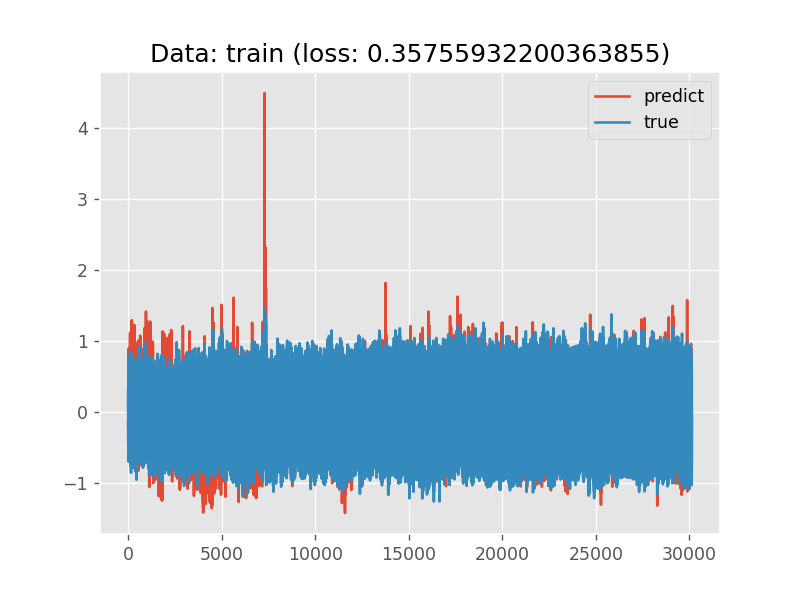

In [10]:
# PLOT PREDICTION VERSUS TRUTH

trainPlotFlag = True
    
if trainPlotFlag:
    x = trainXTensor
    trainTitle = 'train'
else:
    x = validXTensor
    trainTitle = 'valididation'

model.to('cpu')
predict = model(x).cpu().detach().numpy()
model.to(device)

if predict.shape[1] == 1:
    yPred = predict[:,0]
    if trainPlotFlag:
        yTrue = yTrainTimeDomain[:,0]
    else:
        yTrue = yValidTimeDomain[:,0]
else:
    _, yPred = realSTFTtoTimeSeries(predict)
    if trainPlotFlag:
        y = y_trainRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
    else:
        y = y_validRTheta
        _, yTrue = realSTFTtoTimeSeries(y)
        

lossTemp = loss_fn(torch.tensor(yPred), torch.tensor(yTrue)).item()
title = 'Data: ' + trainTitle + ' (loss: %s)' % str(lossTemp)
plt.figure()
plt.plot(yPred, label='predict')
plt.plot(yTrue, label='true')
plt.legend()
plt.title(title)
plt.show()

In [12]:
# SAVE yTRUE and yPRED for conversion to EDF

arraySavePath = '/blue/gkalamangalam/jmark.ettinger/predictScalp/predictionResults/numpy/results_31_Wake_ME1.npz'
np.savez(arraySavePath, yTrue=yTrue, yPred=yPred)

# GET BEST MODEL DATA FROM NEPTUNE

In [17]:
sdm.neptuneBestRun()

https://new-ui.neptune.ai/jettinger35/predictScalp/


,sys/id,best_test_loss,parameters/modelID
0,PRED-67,0.508105,279144
1,PRED-66,0.389803,982815
2,PRED-65,0.677281,228338
3,PRED-64,0.648604,64693
4,PRED-63,0.665345,64693
5,PRED-62,0.676881,64693
6,PRED-61,0.666001,-1
7,PRED-60,0.674732,-1
8,PRED-59,0.391365,-1
13,PRED-54,0.391573,-1


# SCRATCH

In [ ]:
from scipy.signal import spectrogram, stft, istft, check_NOLA

fs = 1
nperseg = 32
noverlap = 31
#windowType = ('tukey', .25)
windowType = np.ones(nperseg)


a = np.random.rand(100)
f, t, S = stft(a, fs=fs, window=windowType, nperseg=nperseg, noverlap=noverlap)

b = torch.stft(torch.tensor(a), 
               n_fft = nperseg, 
               hop_length = 1, 
               return_complex=True, 
               normalized=False, 
               onesided=True, 
               pad_mode='constant').numpy()

np.abs(np.divide(b,S))

In [ ]:
from scipy.signal import get_window
a = get_window(('tukey', .25), nperseg)
a

In [ ]:
'''
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        return loss
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

class NeuralNetwork(nn.Module):
    
    def __init__(self, layerOrderedDict):
        super().__init__()
        self.model = nn.Sequential(layerOrderedDict)
        
    def forward(self, x):
        return self.model(x)
    
    
# GIVEN A LIST OF LAYER SIZES MAKE AN ORDERED DICTIONARY FOR INITIALIZING A PYTORCH NET

def listToOrderedDict(sizeList):
    n = len(sizeList)
    tupleList = []
    for i in range(n - 1):
        tupleList.append(('bn%s' % str(i), nn.BatchNorm1d(sizeList[i])))
        tupleList.append(('l%s' % str(i), nn.Linear(sizeList[i], sizeList[i+1])))
        tupleList.append(('r%s' % str(i), nn.ReLU()))
    return OrderedDict(tupleList[:-1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
'''

'''
    layerSizeList = [trainXTensor.shape[1]] + hiddenLayerSizes + [trainYTensor.shape[1]]
    layerOrderedDict = sdm.listToOrderedDict(layerSizeList)
    model = sdm.NeuralNetwork(layerOrderedDict)
    '''